[통계분석실습 4조] 은행수신상품 가입 여부에 따른 손익 예측을 위한 데이터 분석 프로젝트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

In [2]:
train = pd.read_csv("C:\PDSR/train_SAP.csv", index_col = 0)
test = pd.read_csv("C:\PDSR/test_SAP.csv", index_col = 0)
train.info()
test.info()
    # [train 및 test 데이터 로드]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 25733 to 10327
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4000 non-null   int64  
 1   job             4000 non-null   object 
 2   marital         4000 non-null   object 
 3   education       4000 non-null   object 
 4   default         4000 non-null   object 
 5   housing         4000 non-null   object 
 6   loan            4000 non-null   object 
 7   contact         4000 non-null   object 
 8   month           4000 non-null   object 
 9   day_of_week     4000 non-null   object 
 10  campaign        4000 non-null   int64  
 11  pdays           269 non-null    float64
 12  previous        4000 non-null   int64  
 13  poutcome        4000 non-null   object 
 14  emp.var.rate    4000 non-null   float64
 15  cons.price.idx  4000 non-null   float64
 16  cons.conf.idx   4000 non-null   float64
 17  y               4000 non-nul

In [3]:
train_col = 0
    # [초기화]
train_col = []
    # [리스트 선언]
train_col = train.select_dtypes(include = ["object"]).columns.values
    # [train 데이터의 문자형 변수명을 리스트에 저장]
for feature in train_col:
    train = train.astype({feature : "category"})
        # [train 데이터의 문자형 변수를 범주형으로 변환하는 반복문]

In [4]:
test_col = 0
    # [초기화]
test_col = []
    # [리스트 선언]
test_col = test.select_dtypes(include = ["object"]).columns.values
    # [test 데이터의 문자형 변수명을 리스트에 저장]
for feature in test_col:
    test = test.astype({feature : "category"})
        # [test 데이터의 문자형 변수를 범주형으로 변환하는 반복문]

In [5]:
train.rename(columns = {"emp.var.rate":"emp_var_rate", "cons.price.idx":"cons_price_idx", "cons.conf.idx":"cons_conf_idx"}, inplace = True)
test.rename(columns = {"emp.var.rate":"emp_var_rate", "cons.price.idx":"cons_price_idx", "cons.conf.idx":"cons_conf_idx"},inplace = True)

In [6]:
x = train.drop("y", axis = 1)
x = train.drop("pdays", axis = 1)
y = train["y"]
y = pd.DataFrame(y)

x_training_a, x_validation_a, y_training_a, y_validation_a = train_test_split(x, y, test_size = 0.4, random_state = 2022)
    # [training 및 validation 데이터를 6:4 분할]
x_training_b, x_validation_b, y_training_b, y_validation_b = train_test_split(x, y, test_size = 0.3, random_state = 2022)
    # [training 및 validation 데이터를 7:3 분할]
x_training_c, x_validation_c, y_training_c, y_validation_c = train_test_split(x, y, test_size = 0.2, random_state = 2022)
    # [training 및 validation 데이터를 8: 분할]

In [7]:
print(
    "\n", x_training_a.shape, x_validation_a.shape, y_training_a.shape, y_validation_a.shape,
    "\n", x_training_b.shape, x_validation_b.shape, y_training_b.shape, y_validation_b.shape,
    "\n", x_training_c.shape, x_validation_c.shape, y_training_c.shape, y_validation_c.shape
)


 (2400, 18) (1600, 18) (2400, 1) (1600, 1) 
 (2800, 18) (1200, 18) (2800, 1) (1200, 1) 
 (3200, 18) (800, 18) (3200, 1) (800, 1)


In [8]:
y_training_a = pd.DataFrame(y_training_a)
y_training_a
y_training_a["y"] = y_training_a["y"].astype("object")

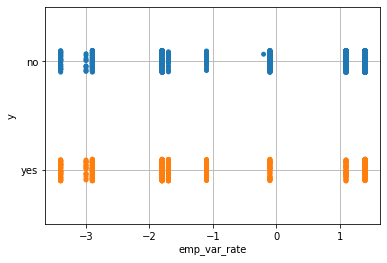

In [9]:
sns.stripplot(y = "y", x = "emp_var_rate", data = train,
             jitter = True, orient = "h")
plt.grid(True)
plt.show()

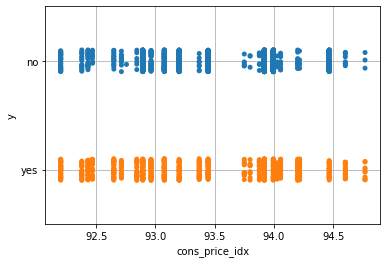

In [10]:
sns.stripplot(y = "y", x = "cons_price_idx", data = train,
             jitter = True, orient = "h")
plt.grid(True)
plt.show()

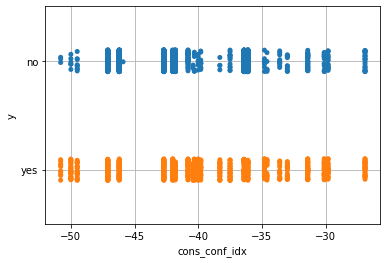

In [11]:
sns.stripplot(y = "y", x = "cons_conf_idx", data = train,
             jitter = True, orient = "h")
plt.grid(True)
plt.show()

1. 이항 로지스틱 회귀분석
https://github.com/grahamharrison68/Public-Github/blob/master/Logistic%20Regression%20Thresholds/Logistic%20Regression%20Thresholds.ipynb

[Trial & Error 1]

In [12]:
def log_odds(features, coefficients, intercept):
    z = np.dot(features, coefficients) + intercept
    return z
        # [내적, dot product]
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
        # [시그모이드 함수]
def log_loss(probabilities, actual_class):
    return np.sum(
        -(1/actual_class.shape[0]) * (actual_class * np.log(probabilities) + (1-actual_class) * np.log(1-probabilities))
    )
        # [prob] log-odds에 sigmoid를 취한 확률 값 
        # [actual_class] 실제 class의 label(target, DV)
        # [데이터에 대한 loss/cost를 계산한 후 loss의 평균]
def predict_class(features, coefficients, intercept, threshold):
    z = log_odds(features, coefficients, intercept)
    a = sigmoid(z)
    return np.where(a >= threshold, 1, 0)

[Trial & Error 2]

In [13]:
from typing import List, Dict, Iterable, Tuple
col = object
columns = List[col]
    #  [타입 어노테이션] 문자열이 포함된 리스트 명시
columns = train.columns.values

for col in columns:
    if col != "generation":
        print(col, end = " + ")
    else: 
        print(col)

age + job + marital + education + default + housing + loan + contact + month + day_of_week + campaign + pdays + previous + poutcome + emp_var_rate + cons_price_idx + cons_conf_idx + y + generation


In [14]:
'''
glm_a = sm.Logit.from_formula("y ~ age + education", data = x_training_a).fit()
glm_a.summary()
y_prob = glm_a.predict(x_training_a)
y_pred = list(map(threshold, y_prob))
'''

logit_a = sm.Logit.from_formula("y ~ age + job + marital + education + default + housing + loan + contact + month + day_of_week + campaign + previous + poutcome + emp_var_rate + cons_price_idx + cons_conf_idx + y + generation", train)
logistic_a = logit_mod.fit(disp = 0)
    # [최적화 과정에서 문자열 메세지를 나타내지 않는 역할]
logistic_a.summary()
y_pred = logistic_a.predict(X) >= 
    # [threshold]

train["prediction"] = logistic_a.predict(train)
sns.boxplot(x = "y", y = "prediction", data = train)
plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_17232/3121915196.py, line 12)

[Trial & Error 3]

In [15]:
def user_cost_function(TP, TN, FN, FP):
    cost = 0
        # [초기화]
    cost += (TP * 5)
    cost += (TN * -2)
    cost += (FN * -3)
    cost += (FP * 0)
    
    return cost

In [16]:
class LogisticRegressionThreshold(LogisticRegression):
    def predict(self, X, threshold = None):
        
        if threshold == None: 
            # [threshold = 0.5]
            return LogisticRegression.predict(self, x)
        
        else:
            y_scores = LogisticRegression.predict_proba(self, x)[:, 1]
            y_pred_thre = (y_scores >= threshold).astype(int)

            return y_pred_thre
        
    def threshold_with_costfunction(self, x, y, cost_function):
    
        y_socres = LogisticRegression.predict_proba(self, x)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
        Costs = []
        TPs = []
        TNs = []
        FNs = []
        FPs = []
        
        for threshold in thresholds:
            y_pred_with_threshold = (y_scores >= threshold).astype(int)
            TP, TN, FN, FP = confusion_matrix(y, y_pred_with_threshold).ravel()
            
            Costs.append(user_cost_function(TP, TN, FN, FP))
            TPs.append(TP), TNs.append(TN), FNs.append(FN), FPs.append(FP)
        cost_df = pd.DataFrame({
            "precision":precisions[:-1],
            "recall":recalls[:-1],
            "threshold":thresholds,
            "cost":Costs,
            "TP":TPs, "TN":TNs, "FN":FNs, "FP":FPs
        })
    
        cost_min = cost_df[cost_df["cost"] == cost_min].iloc[0]["threshold"]
    
        return threshold, cost_min, cost_df

In [17]:
logit_thre = LogisticRegressionThreshold()
logit_a = logit_thre.fit(x_training_a, y_training_a, range(0.05, 0.95, 0.05))

threshold, cost_min, cost_df = logit_thre.threshold_with_costfunction(x_training_6, y_training_6, user_cost_function)
y_pred = logit_a.predict(x_training_a, threshold)
threshold, min_cost

TypeError: 'float' object cannot be interpreted as an integer

[Trial & Error 4]